In [70]:
from json import load
with open("useful2.json") as f:
  full_log = load(f)

In [71]:
hosts = list(full_log.keys())
intervals = list(full_log[hosts[0]].keys())
lengths = list(full_log[hosts[0]][intervals[0]].keys())
sides = list(full_log[hosts[0]][intervals[0]][lengths[0]].keys())
metrics = list(full_log[hosts[0]][intervals[0]][lengths[0]][sides[0]].keys())

In [121]:
differences = dict()
for host in hosts:
  differences[host] = dict()
  for interval in intervals:
    differences[host][interval] = dict()
    for length in lengths:
      differences[host][interval][length] = dict()
      for metric in metrics[:2]:
        differences[host][interval][length][metric] = full_log[host][interval][length]["client"][metric] - full_log[host][interval][length]["server"][metric]
        differences[host][interval][length][metric + "_loss_ratio"] = differences[host][interval][length][metric] / full_log[host][interval][length]["client"][metric]
      differences[host][interval][length]["time"] = max(full_log[host][interval][length]["client"]["time"], full_log[host][interval][length]["server"]["time"])
      differences[host][interval][length]["data_rate"] = full_log[host][interval][length]["server"]["data"] / differences[host][interval][length]["time"] / 1024 * 8
# differences

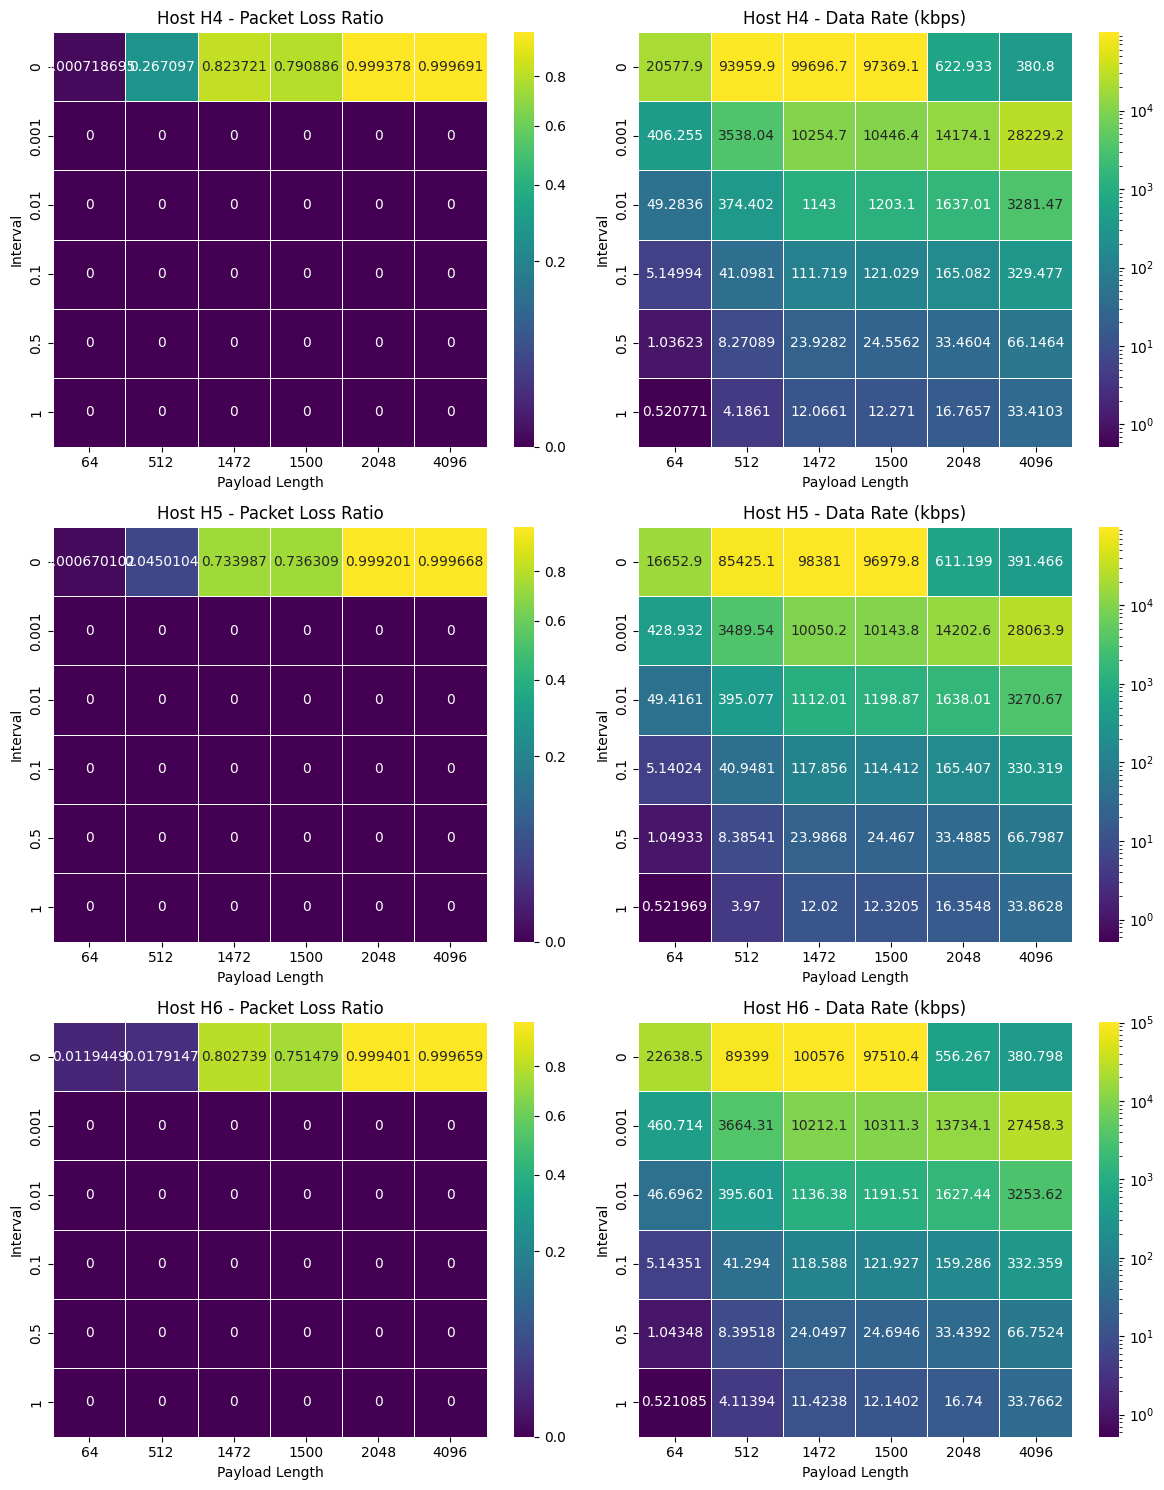

In [ ]:
from matplotlib.colors import LogNorm, PowerNorm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

heatmaps_data = dict()
diff_metrics = ["sent_loss_ratio", "data_rate"]
for host in hosts:
  heatmaps_data[host] = dict()
  for metric in diff_metrics:
    # Prepare data for DataFrame
    data_for_df = []
    for interval in intervals:
      row_data = []
      for length in lengths:
        row_data.append(differences[host][interval][length][metric])
      data_for_df.append(row_data)

    # Create DataFrame
    df = pd.DataFrame(data_for_df, index=intervals, columns=lengths)
    heatmaps_data[host][metric] = df

for metric in diff_metrics:
  heatmaps_data["Average"][metric] = (heatmaps_data["H4"][metric] + heatmaps_data["H5"][metric] + heatmaps_data["H6"][metric]) / 3

num_hosts = len(hosts) + 1
num_diff_metrics = len(diff_metrics)

fig, axes = plt.subplots(num_hosts, num_diff_metrics, figsize=(num_diff_metrics * 6, num_hosts * 5))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

plot_idx = 0
for host in hosts:
  for metric in diff_metrics:
    df_to_plot = heatmaps_data[host][metric]

    ax = axes[plot_idx]
    if "rate" in metric:
      norm = LogNorm()
    else:
      norm = PowerNorm(gamma=.5)
    sns.heatmap(df_to_plot, annot=True, fmt=".6g", cmap='viridis', linewidths=.5, ax=ax, norm=norm)
    title = f'Host {host} - {metric.replace("sent", "packet").replace("_", " ").title().replace("Rate", "Rate (kbps)")}'
    ax.set_title(title)
    ax.set_xlabel('Payload Length')
    ax.set_ylabel('Interval')
    plot_idx += 1

plt.tight_layout()
plt.show()